In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Model Deployment for the utilitarian dataset 

# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/2 FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target variable
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
                      'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE','RatingC']
target = 'helpful'



# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
    remainder='passthrough'  # Keep all other columns in the DataFrame
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=features)


# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [5]:
## Perform stratified K-fold cross-validation for classification with a combined stratification column 'stratify' to ensure balanced class distribution in each fold
# This column is created by combining 'helpful' and 'Prod' columns as strings.
# It uses StratifiedKFold with 10 splits, ensuring each fold preserves the percentage of samples for each class label (With respect to product category and distribution of helpful reviews)

from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print shap of the df
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Check the stratify distribution
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840617
1    0.159383
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840859
1    0.159141
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify distribution:
 helpful
0    0.840678
1    0.159322
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.840308
1    0.159692
Name: proportion, dtype: float64
X_train shape: (16338, 15)
X_test shape: (1816, 15)
y_train shape: (16338,)
y_test shape: (1816,)
Train stratify di

## 2.1 Data Augmentation 
In the next steps SMOTE is applied to the dataset since it was highly imbalanced, this ensured that the minority class is better represented in the data. 

In [6]:
# Applying SMOTE to the training data to ensure balanced class distribution, increase minority class to 8000 samples

from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13736
1     2603
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13736
1     8000
Name: count, dtype: int64


# 3. Model Building 

The following sections detail the steps for model deployment using Logistic Regression and Gradient Boosting, both applied to the SMOTE-enhanced dataset. For performance evaluation the metrics ACC, F1 and AUC were used.

## 3.1 Logistic Regression

In [7]:
#Using Logistic Regression as Baseline Model 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  

# Train the model
logreg_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
cls_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(cls_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

LR_results = pd.DataFrame(results_dict)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Logistic Regression Model Evaluation:
Accuracy: 0.7779614325068871
F1 Score: 0.41678726483357453
AUC: 0.6640135669869983
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1525
           1       0.36      0.50      0.42       290

    accuracy                           0.78      1815
   macro avg       0.63      0.66      0.64      1815
weighted avg       0.81      0.78      0.79      1815

Confusion Matrix:
 [[1268  257]
 [ 146  144]]
Mean Cross-Validated Accuracy: 0.6777208805827661


## 3.2 Random Forest

Exploring other machine learning approaches to evaluate their performance.

In [8]:
# Using Random Forest Classifier as a more complex model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Initialize the logistic regression model
RF_model = RandomForestClassifier()  

# Train the model
RF_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = RF_model.predict(X_test)


print("\nRandom Forest Model Evaluation:")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
cls_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(cls_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)



Random Forest Model Evaluation:
Accuracy: 0.8534435261707989
F1 Score: 0.4981132075471698
AUC: 0.6921763708309779
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1525
           1       0.55      0.46      0.50       290

    accuracy                           0.85      1815
   macro avg       0.72      0.69      0.71      1815
weighted avg       0.84      0.85      0.85      1815

Confusion Matrix:
 [[1417  108]
 [ 158  132]]


## 3.2 Extreme Gradient Boosting

For Extreme Gradient Boosting, the first step involved applying the model to the original dataset to demonstrate the improvement in F1 score due to SMOTE. The next step involved deploying the model on the SMOTE-enhanced dataset. Finally, hyperparameter tuning was applied.

In [9]:
# Starting of XGBoost with unbalanced data (No SMOTE applied) to evaluate improvement due to SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
print("\nDefault XGBoost Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_default)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
cls_report = classification_report(y_test, y_pred_default)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default XGBoost Evaluation:
Accuracy: 0.8672176308539945
F1 Score: 0.4883227176220807
AUC: 0.6766365178066704
Confusion Matrix:
 [[1459   66]
 [ 175  115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1525
           1       0.64      0.40      0.49       290

    accuracy                           0.87      1815
   macro avg       0.76      0.68      0.71      1815
weighted avg       0.85      0.87      0.85      1815

Mean Cross-Validated Accuracy: 0.8105782239141537


In [10]:
# Train model with SMOTE balanced data, using the same hyperparameters as the default model
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
cls_report = classification_report(y_test, y_pred_SMOTE)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost SMOTE'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_results = pd.DataFrame(results_dict)

\SMOTE Model Evaluation:
Accuracy: 0.8666666666666667
F1 Score: 0.5310077519379844
AUC: 0.7070265686828716
Confusion Matrix:
 [[1436   89]
 [ 153  137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1525
           1       0.61      0.47      0.53       290

    accuracy                           0.87      1815
   macro avg       0.75      0.71      0.73      1815
weighted avg       0.86      0.87      0.86      1815

Mean Cross-Validated Accuracy: 0.7800967008938691


### 3.2.1 XGradBoost Hyperparameter Tuning

In the following hyperparamter tuning is applied to improve the XGBoost model with Bayesian Optimization. 

In [11]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = int(space['gamma']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 200,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8523415977961433                                     
  0%|          | 1/200 [00:00<00:38,  5.14trial/s, best loss: -0.8523415977961433]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.856198347107438                                                                 
  1%|          | 2/200 [00:00<00:37,  5.26trial/s, best loss: -0.856198347107438] 

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                           
0.8556473829201102                                                               
SCORE:                                                                           
0.859504132231405                                                                
  2%|▏         | 4/200 [00:00<00:37,  5.29trial/s, best loss: -0.859504132231405]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                           
0.8479338842975207                                                               
SCORE:                                                                           
0.8628099173553719                                                               
  3%|▎         | 6/200 [00:01<00:33,  5.76trial/s, best loss: -0.8628099173553719]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8639118457300275                                                                
  4%|▎         | 7/200 [00:01<00:37,  5.09trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8639118457300275                                                                
SCORE:                                                                            
0.8512396694214877                                                                
  4%|▍         | 9/200 [00:01<00:38,  4.98trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8617079889807162                                                                
  5%|▌         | 10/200 [00:01<00:35,  5.41trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
SCORE:                                                                             
0.8573002754820936                                                                 
  6%|▌         | 12/200 [00:02<00:34,  5.44trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8429752066115702                                                                 
SCORE:                                                                             
0.8484848484848485                                                                 
  7%|▋         | 14/200 [00:02<00:36,  5.16trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8545454545454545                                                                 
  8%|▊         | 15/200 [00:02<00:32,  5.64trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
SCORE:                                                                             
0.8495867768595041                                                                 
  8%|▊         | 17/200 [00:03<00:31,  5.79trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617079889807162                                                                 
SCORE:                                                                             
0.859504132231405                                                                  
 10%|▉         | 19/200 [00:03<00:29,  6.19trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
 10%|█         | 20/200 [00:03<00:29,  6.07trial/s, best loss: -0.8639118457300275]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
SCORE:                                                                             
0.8666666666666667                                                                 
 11%|█         | 22/200 [00:04<00:33,  5.32trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8589531680440772                                                                 
 12%|█▏        | 24/200 [00:04<00:34,  5.12trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.859504132231405                                                                  
 13%|█▎        | 26/200 [00:04<00:31,  5.46trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8517906336088155                                                                 
SCORE:                                                                             
0.8556473829201102                                                                 
 14%|█▍        | 28/200 [00:05<00:31,  5.47trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8556473829201102                                                                 
SCORE:                                                                             
0.8534435261707989                                                                 
 15%|█▌        | 30/200 [00:05<00:33,  5.05trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
 16%|█▌        | 31/200 [00:05<00:37,  4.45trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
 16%|█▌        | 32/200 [00:06<00:41,  4.02trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
 16%|█▋        | 33/200 [00:06<00:42,  3.94trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8622589531680441                                                                 
 17%|█▋        | 34/200 [00:06<00:40,  4.11trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628099173553719                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
 18%|█▊        | 36/200 [00:07<00:36,  4.53trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
 18%|█▊        | 37/200 [00:07<00:31,  5.10trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8622589531680441                                                                 
 19%|█▉        | 38/200 [00:07<00:32,  4.92trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8512396694214877                                                                 
SCORE:                                                                             
0.8650137741046832                                                                 
 20%|██        | 40/200 [00:07<00:32,  4.98trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8528925619834711                                                                 
SCORE:                                                                             
0.8622589531680441                                                                 
 21%|██        | 42/200 [00:08<00:28,  5.61trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
 22%|██▏       | 43/200 [00:08<00:28,  5.52trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8600550964187328                                                                 
SCORE:                                                                             
0.8622589531680441                                                                 
 22%|██▎       | 45/200 [00:08<00:29,  5.21trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
 24%|██▎       | 47/200 [00:09<00:28,  5.37trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8495867768595041                                                                 
SCORE:                                                                             
0.8556473829201102                                                                 
 24%|██▍       | 49/200 [00:09<00:29,  5.04trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8545454545454545                                                                 
 25%|██▌       | 50/200 [00:09<00:31,  4.71trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
 26%|██▌       | 51/200 [00:10<00:31,  4.70trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
 26%|██▌       | 52/200 [00:10<00:45,  3.23trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617079889807162                                                                 
 26%|██▋       | 53/200 [00:11<00:50,  2.89trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
 27%|██▋       | 54/200 [00:11<00:55,  2.62trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
 28%|██▊       | 55/200 [00:12<01:04,  2.24trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8457300275482094                                                                 
 28%|██▊       | 56/200 [00:12<00:54,  2.62trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
 28%|██▊       | 57/200 [00:12<00:56,  2.52trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8506887052341597                                                                 
 29%|██▉       | 58/200 [00:13<00:54,  2.59trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8699724517906336                                                                 
 30%|██▉       | 59/200 [00:13<01:13,  1.91trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
 30%|███       | 60/200 [00:14<01:07,  2.07trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.843526170798898                                                                  
 30%|███       | 61/200 [00:14<01:00,  2.29trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8611570247933884                                                                 
 31%|███       | 62/200 [00:15<01:10,  1.95trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
 32%|███▏      | 63/200 [00:15<00:59,  2.32trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8578512396694215                                                                 
SCORE:                                                                             
0.8600550964187328                                                                 
 32%|███▎      | 65/200 [00:16<00:49,  2.70trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865564738292011                                                                  
 33%|███▎      | 66/200 [00:16<00:47,  2.82trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8650137741046832                                                                 
 34%|███▎      | 67/200 [00:16<00:45,  2.94trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8584022038567493                                                                 
 34%|███▍      | 68/200 [00:17<00:50,  2.64trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661157024793389                                                                 
 34%|███▍      | 69/200 [00:17<00:47,  2.78trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8506887052341597                                                                 
 35%|███▌      | 70/200 [00:17<00:42,  3.04trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8523415977961433                                                                 
 36%|███▌      | 71/200 [00:18<00:40,  3.19trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
 36%|███▌      | 72/200 [00:18<00:42,  3.01trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8589531680440772                                                                 
SCORE:                                                                             
0.8589531680440772                                                                 
 37%|███▋      | 74/200 [00:19<00:35,  3.56trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8484848484848485                                                                 
 38%|███▊      | 75/200 [00:19<00:32,  3.85trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8633608815426997                                                                 
SCORE:                                                                             
0.8517906336088155                                                                 
 38%|███▊      | 77/200 [00:19<00:28,  4.32trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8606060606060606                                                                 
 39%|███▉      | 78/200 [00:20<00:29,  4.10trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8490358126721763                                                                 
 40%|███▉      | 79/200 [00:20<00:31,  3.78trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8672176308539945                                                                 
 40%|████      | 80/200 [00:20<00:35,  3.40trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.859504132231405                                                                  
 40%|████      | 81/200 [00:21<00:35,  3.34trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.856198347107438                                                                  
 41%|████      | 82/200 [00:21<00:34,  3.42trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8528925619834711                                                                 
 42%|████▏     | 83/200 [00:21<00:35,  3.29trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8512396694214877                                                                 
 42%|████▏     | 84/200 [00:22<00:50,  2.32trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
 42%|████▎     | 85/200 [00:22<00:50,  2.27trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8528925619834711                                                                 
 43%|████▎     | 86/200 [00:23<00:52,  2.18trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628099173553719                                                                 
SCORE:                                                                             
0.8584022038567493                                                                 
 44%|████▍     | 88/200 [00:23<00:44,  2.53trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8633608815426997                                                                 
 44%|████▍     | 89/200 [00:24<00:49,  2.25trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8573002754820936                                                                 
 45%|████▌     | 90/200 [00:24<00:46,  2.37trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865564738292011                                                                  
 46%|████▌     | 91/200 [00:26<01:09,  1.57trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8650137741046832                                                                 
 46%|████▌     | 92/200 [00:26<01:17,  1.39trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8501377410468319                                                                 
SCORE:                                                                             
0.8523415977961433                                                                 
 47%|████▋     | 94/200 [00:27<00:49,  2.12trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
 48%|████▊     | 95/200 [00:27<00:40,  2.62trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8650137741046832                                                                 
 48%|████▊     | 96/200 [00:27<00:35,  2.93trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617079889807162                                                                 
SCORE:                                                                             
0.8528925619834711                                                                 
 49%|████▉     | 98/200 [00:28<00:27,  3.77trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8534435261707989                                                                 
 50%|████▉     | 99/200 [00:28<00:23,  4.32trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8550964187327824                                                                 
 50%|█████     | 100/200 [00:28<00:24,  4.05trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
SCORE:                                                                              
0.8584022038567493                                                                  
 51%|█████     | 102/200 [00:29<00:29,  3.29trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8550964187327824                                                                  
 52%|█████▏    | 103/200 [00:30<00:39,  2.48trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8644628099173554                                                                  
SCORE:                                                                              
0.8512396694214877                                                                  
 52%|█████▎    | 105/200 [00:30<00:27,  3.43trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8429752066115702                                                                  
 53%|█████▎    | 106/200 [00:30<00:27,  3.47trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
 54%|█████▎    | 107/200 [00:31<00:28,  3.31trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
 54%|█████▍    | 108/200 [00:31<00:36,  2.51trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8584022038567493                                                                  
 55%|█████▍    | 109/200 [00:32<00:42,  2.16trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8644628099173554                                                                  
SCORE:                                                                              
0.856198347107438                                                                   
 56%|█████▌    | 111/200 [00:32<00:30,  2.96trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8628099173553719                                                                  
 56%|█████▌    | 112/200 [00:32<00:25,  3.45trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8666666666666667                                                                  
 56%|█████▋    | 113/200 [00:33<00:24,  3.58trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8611570247933884                                                                  
SCORE:                                                                              
0.8528925619834711                                                                  
 57%|█████▊    | 115/200 [00:33<00:20,  4.22trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8457300275482094                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 58%|█████▊    | 117/200 [00:33<00:16,  4.91trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
SCORE:                                                                              
0.8589531680440772                                                                  
 60%|█████▉    | 119/200 [00:34<00:18,  4.38trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8556473829201102                                                                  
 60%|██████    | 120/200 [00:34<00:18,  4.38trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8661157024793389                                                                  
 60%|██████    | 121/200 [00:34<00:18,  4.22trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8672176308539945                                                                  
 61%|██████    | 122/200 [00:35<00:18,  4.20trial/s, best loss: -0.8699724517906336]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8550964187327824                                                                  
SCORE:                                                                              
0.8705234159779615                                                                  
 62%|██████▏   | 124/200 [00:35<00:17,  4.32trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
 62%|██████▎   | 125/200 [00:35<00:16,  4.67trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8584022038567493                                                                  
SCORE:                                                                              
0.8528925619834711                                                                  
 64%|██████▎   | 127/200 [00:36<00:14,  5.20trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
 64%|██████▍   | 128/200 [00:36<00:13,  5.38trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8534435261707989                                                                  
 64%|██████▍   | 129/200 [00:36<00:12,  5.53trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.856198347107438                                                                   
SCORE:                                                                              
0.856198347107438                                                                   
 66%|██████▌   | 131/200 [00:36<00:12,  5.50trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8484848484848485                                                                  
SCORE:                                                                              
0.8600550964187328                                                                  
 66%|██████▋   | 133/200 [00:37<00:11,  5.64trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
 67%|██████▋   | 134/200 [00:37<00:11,  5.73trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8650137741046832                                                                  
SCORE:                                                                              
0.8556473829201102                                                                  
 68%|██████▊   | 136/200 [00:37<00:11,  5.70trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8589531680440772                                                                  
 68%|██████▊   | 137/200 [00:38<00:11,  5.47trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8523415977961433                                                                  
 69%|██████▉   | 138/200 [00:38<00:12,  5.13trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8617079889807162                                                                  
 70%|██████▉   | 139/200 [00:38<00:12,  4.91trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8528925619834711                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 70%|███████   | 141/200 [00:38<00:12,  4.65trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
 71%|███████   | 142/200 [00:39<00:12,  4.51trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8661157024793389                                                                  
SCORE:                                                                              
0.8550964187327824                                                                  
 72%|███████▏  | 144/200 [00:39<00:13,  4.29trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8545454545454545                                                                  
 72%|███████▎  | 145/200 [00:39<00:11,  4.79trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8473829201101928                                                                  
 73%|███████▎  | 146/200 [00:40<00:12,  4.37trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8611570247933884                                                                  
SCORE:                                                                              
0.846831955922865                                                                   
 74%|███████▍  | 148/200 [00:40<00:13,  3.96trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8611570247933884                                                                  
 74%|███████▍  | 149/200 [00:40<00:12,  3.98trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8672176308539945                                                                  
 75%|███████▌  | 150/200 [00:41<00:12,  3.94trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8672176308539945                                                                  
SCORE:                                                                              
0.8650137741046832                                                                  
 76%|███████▌  | 152/200 [00:41<00:11,  4.30trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8650137741046832                                                                  
SCORE:                                                                              
0.8611570247933884                                                                  
 77%|███████▋  | 154/200 [00:42<00:09,  4.76trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
SCORE:                                                                              
0.8584022038567493                                                                  
 78%|███████▊  | 155/200 [00:42<00:08,  5.22trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



 78%|███████▊  | 156/200 [00:42<00:08,  4.98trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.856198347107438                                                                   
SCORE:                                                                              
0.8556473829201102                                                                  
 79%|███████▉  | 158/200 [00:42<00:09,  4.56trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8556473829201102                                                                  
 80%|███████▉  | 159/200 [00:43<00:10,  3.98trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8429752066115702                                                                  
 80%|████████  | 160/200 [00:43<00:15,  2.53trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8556473829201102                                                                  
 80%|████████  | 161/200 [00:44<00:15,  2.49trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8534435261707989                                                                  
SCORE:                                                                              


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8573002754820936
 82%|████████▏ | 163/200 [00:44<00:12,  2.92trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8473829201101928                                                                  
SCORE:                                                                              
0.8550964187327824                                                                  
 82%|████████▎ | 165/200 [00:45<00:10,  3.42trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.859504132231405                                                                   
SCORE:                                                                              
0.8578512396694215                                                                  
 84%|████████▎ | 167/200 [00:45<00:08,  3.78trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8606060606060606                                                                  
 84%|████████▍ | 168/200 [00:46<00:07,  4.05trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
 84%|████████▍ | 168/200 [00:46<00:07,  4.05trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8611570247933884                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 85%|████████▌ | 170/200 [00:46<00:06,  4.56trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8512396694214877                                                                  
SCORE:                                                                              
 86%|████████▌ | 171/200 [00:47<00:06,  4.25trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8628099173553719                                                                  
SCORE:                                                                              
0.8589531680440772                                                                  
 86%|████████▋ | 173/200 [00:47<00:06,  4.42trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8639118457300275                                                                  
 87%|████████▋ | 174/200 [00:47<00:05,  4.71trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8550964187327824                                                                  
 88%|████████▊ | 175/200 [00:47<00:05,  4.94trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8633608815426997                                                                  
SCORE:                                                                              
0.8606060606060606                                                                  
 88%|████████▊ | 177/200 [00:47<00:04,  5.15trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8473829201101928                                                                  
SCORE:                                                                              
0.8545454545454545                                                                  
 90%|████████▉ | 179/200 [00:48<00:04,  4.86trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8633608815426997                                                                  
SCORE:                                                                              
0.8528925619834711                                                                  
 90%|█████████ | 181/200 [00:49<00:05,  3.67trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8479338842975207                                                                  
 91%|█████████ | 182/200 [00:49<00:04,  4.11trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8550964187327824                                                                  
SCORE:                                                                              
0.8545454545454545                                                                  
 92%|█████████▏| 184/200 [00:49<00:04,  3.95trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8617079889807162                                                                  
SCORE:                                                                              
0.8550964187327824                                                                  
 93%|█████████▎| 186/200 [00:50<00:03,  3.76trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8628099173553719                                                                  
SCORE:                                                                              
0.8556473829201102                                                                  
 94%|█████████▍| 188/200 [00:50<00:02,  4.29trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8556473829201102                                                                  
SCORE:                                                                              
0.8556473829201102                                                                  
 95%|█████████▌| 190/200 [00:51<00:01,  5.23trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8495867768595041                                                                  
 96%|█████████▌| 191/200 [00:51<00:02,  4.47trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.865564738292011                                                                   
SCORE:                                                                              
0.8545454545454545                                                                  
 96%|█████████▋| 193/200 [00:51<00:01,  4.44trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8578512396694215                                                                  
 97%|█████████▋| 194/200 [00:52<00:01,  4.78trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.865564738292011                                                                   
SCORE:                                                                              
0.8639118457300275                                                                  
 98%|█████████▊| 196/200 [00:52<00:00,  4.80trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8584022038567493                                                                  
SCORE:                                                                              
0.8628099173553719                                                                  
 99%|█████████▉| 198/200 [00:53<00:00,  4.37trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8462809917355372                                                                  
100%|█████████▉| 199/200 [00:53<00:00,  4.27trial/s, best loss: -0.8705234159779615]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                              
0.8573002754820936                                                                  
100%|██████████| 200/200 [00:53<00:00,  3.73trial/s, best loss: -0.8705234159779615]
The best hyperparameters are :  

{'colsample_bytree': 0.5096165946290121, 'gamma': 1.9958159647230012, 'max_depth': 13.0, 'min_child_weight': 1.0, 'n_estimators': 100.0, 'reg_lambda': 3.5428100540658387}


In [13]:
# Save the best hyperparameters in a dictionary for model implementation and evaluation
best_hyperparams={'colsample_bytree': 0.7716761454118004, 'gamma': 1.9708066405788685, 'max_depth': 7, 'min_child_weight': 10, 'n_estimators': 150, 'reg_lambda': 8.695328541345564}



In [14]:
# With considering inbalanced data applying Weighted XGBoost
# Calculate class distribution3

from collections import Counter
sqrt = np.sqrt

# Count the class distribution in the training set
counts = y_train_balanced.value_counts()
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13736
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [15]:
# Train model with modified hyperparameters and scale_pos_weight
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation ACCURACY
accuracy = accuracy_score(y_test, y_pred_opt)
print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_opt)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
cls_report = classification_report(y_test, y_pred_opt)
print("Classification Report:")
print(cls_report)


# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost with Hyperparameters'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Hyp_results = pd.DataFrame(results_dict)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8578512396694215
F1 Score: 0.5342960288808664
AUC: 0.7171396269078576
Confusion Matrix:
 [[1409  116]
 [ 142  148]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1525
           1       0.56      0.51      0.53       290

    accuracy                           0.86      1815
   macro avg       0.73      0.72      0.73      1815
weighted avg       0.85      0.86      0.86      1815

Mean Cross-Validated Accuracy: 0.7573686258898851


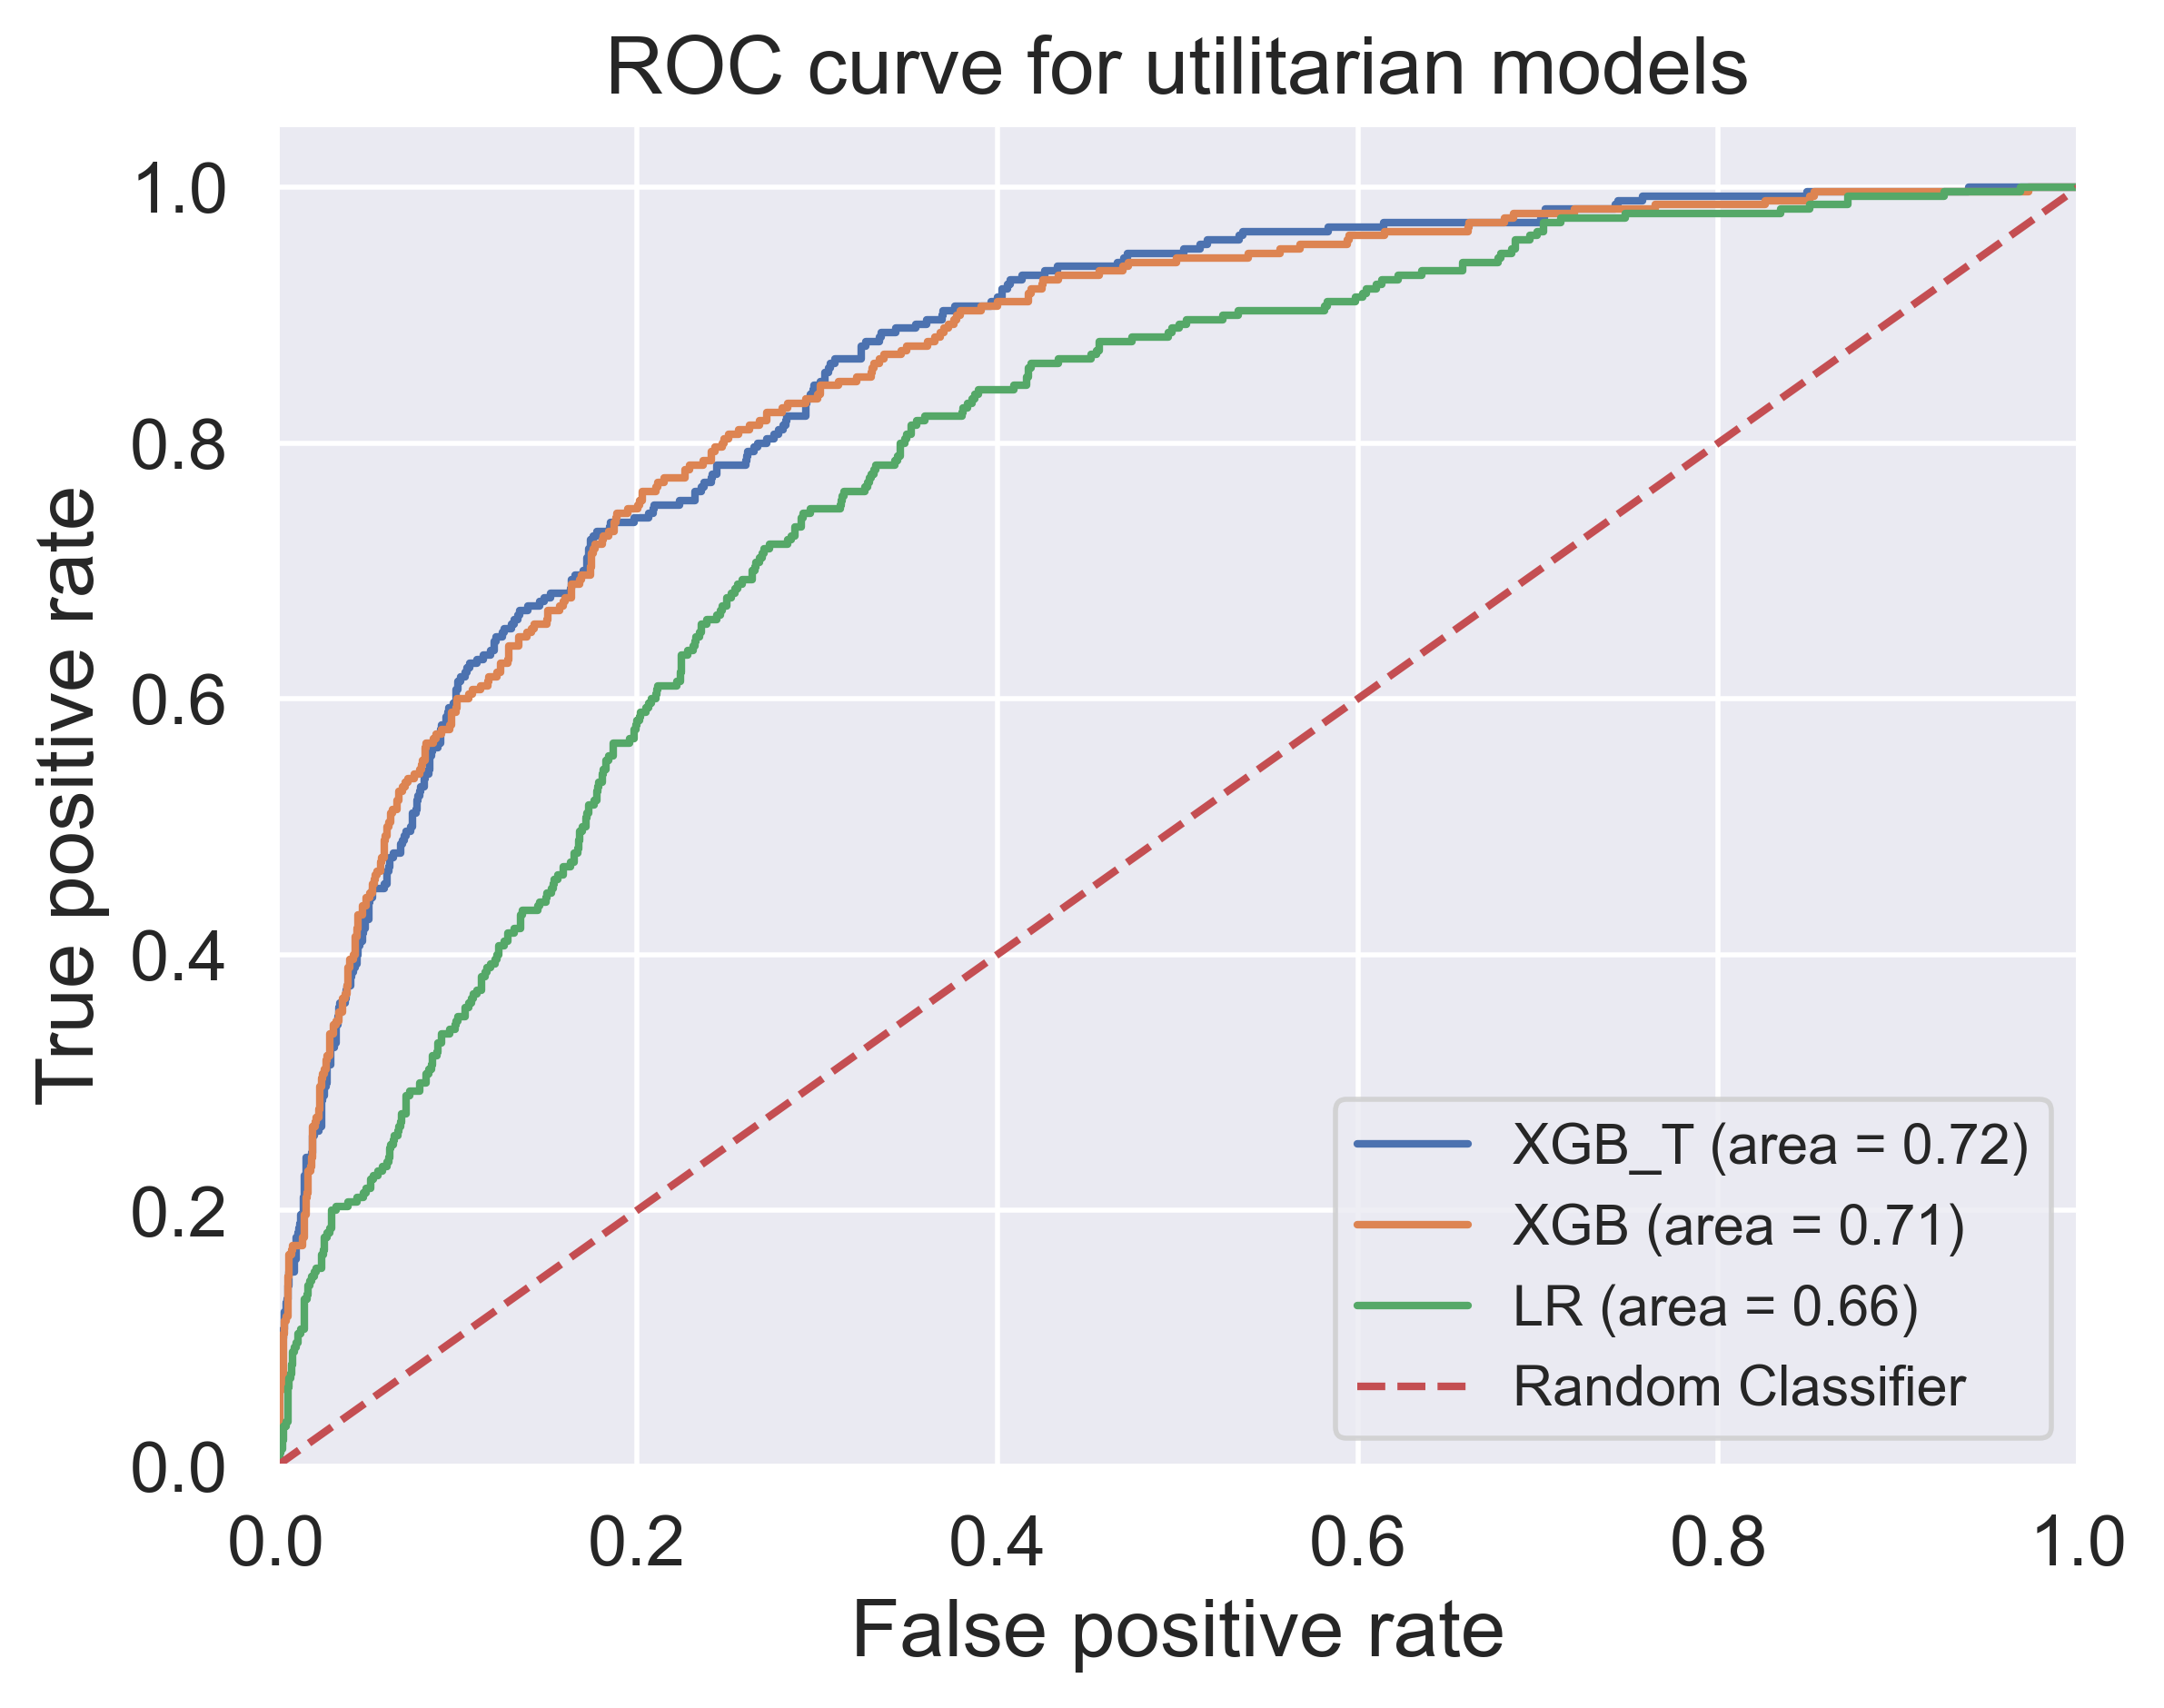

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

sns.set(style='darkgrid')
# Calculate ROC AUC and curves for xgb_cls_hyp
logit_roc_auc_hyp = roc_auc_score(y_test, xgb_cls_hyp.predict(X_test))
fpr_hyp, tpr_hyp, thresholds_hyp = roc_curve(y_test, xgb_cls_hyp.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for logreg_model
logit_roc_auc_logreg = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for xgb_cls_SMOTE
logit_roc_auc_smote = roc_auc_score(y_test, xgb_cls_SMOTE.predict(X_test))
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, xgb_cls_SMOTE.predict_proba(X_test)[:,1])

# Plotting the ROC curves
plt.figure(dpi=400)
plt.plot(fpr_hyp, tpr_hyp, label='XGB_T (area = %0.2f)' % logit_roc_auc_hyp)
plt.plot(fpr_smote, tpr_smote, label='XGB (area = %0.2f)' % logit_roc_auc_smote)
plt.plot(fpr_logreg, tpr_logreg, label='LR (area = %0.2f)' % logit_roc_auc_logreg)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier ')

# Setting plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase major tick label size
plt.tick_params(axis='both', which='minor', labelsize=14)  # Increase minor tick label size
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC curve for utilitarian models', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('ROC_Utilitarian.png',dpi=800)
plt.show()


# 4. Model Comparision

Summarizing AUC; ACC and F1 Score for different models and comparing them. 

In [17]:
results = pd.concat([LR_results, XGB_results, XGB_Hyp_results], axis=0)
print(results)

                          Model  Accuracy  F1 Score       AUC
0           Logistic Regression  0.777961  0.416787  0.664014
0                 XGBoost SMOTE  0.866667  0.531008  0.707027
0  XGBoost with Hyperparameters  0.857851  0.534296  0.717140




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



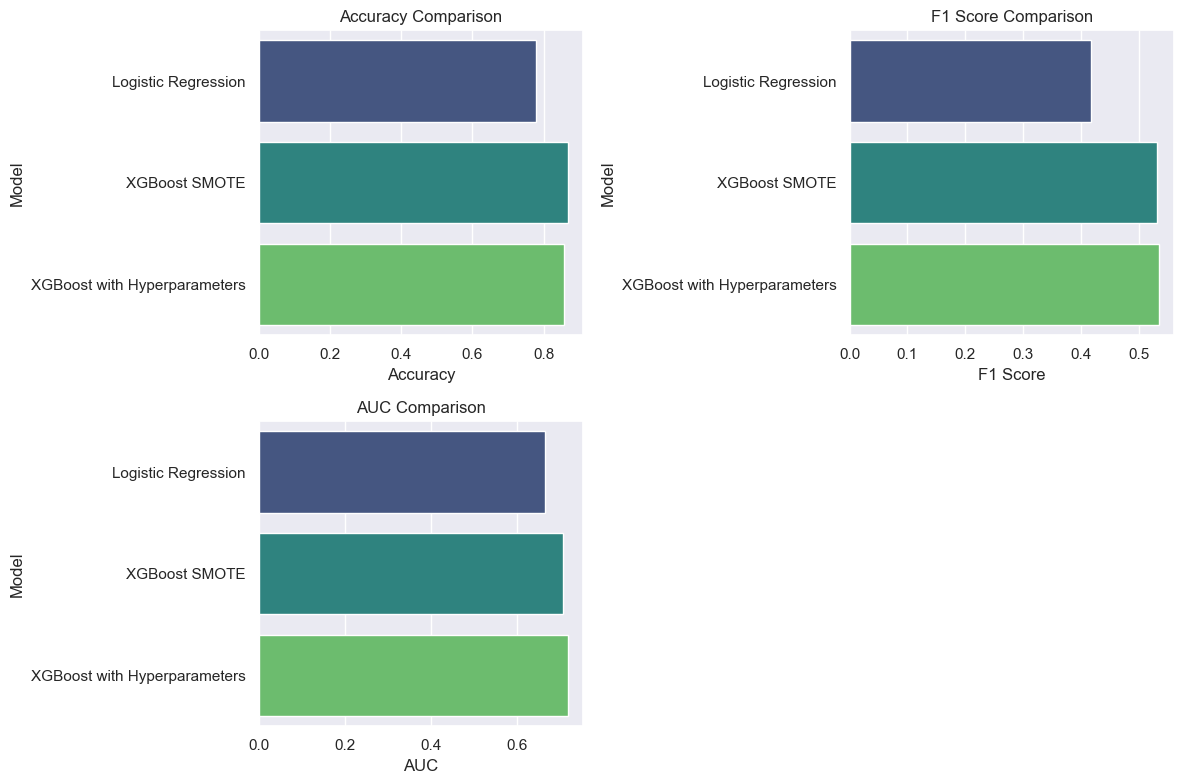

In [18]:
# Plotting the comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')

# Plot 2: F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=results, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')

# Plot 3: AUC
plt.subplot(2, 2, 3)
sns.barplot(x='AUC', y='Model', data=results, palette='viridis')
plt.title('AUC Comparison')
plt.xlabel('AUC')

plt.tight_layout()
plt.show()

# 5. Feature Importance with Shap Values

The next steps include the application of SHAP value analysis for the XGBoost hyperparameter tuned utilitarian model. 

[13:26:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 21243/21736 [00:25<00:00]        

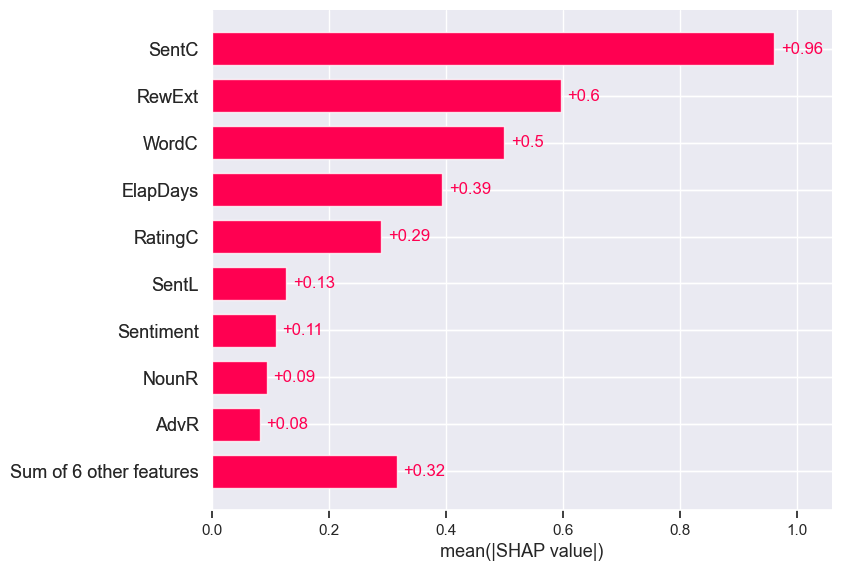

In [19]:
# SHAP values for the best model (XGBoost with hyperparameters)
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.bar(shap_values.abs.mean(0))

[13:26:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 96%|=================== | 20954/21736 [00:25<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


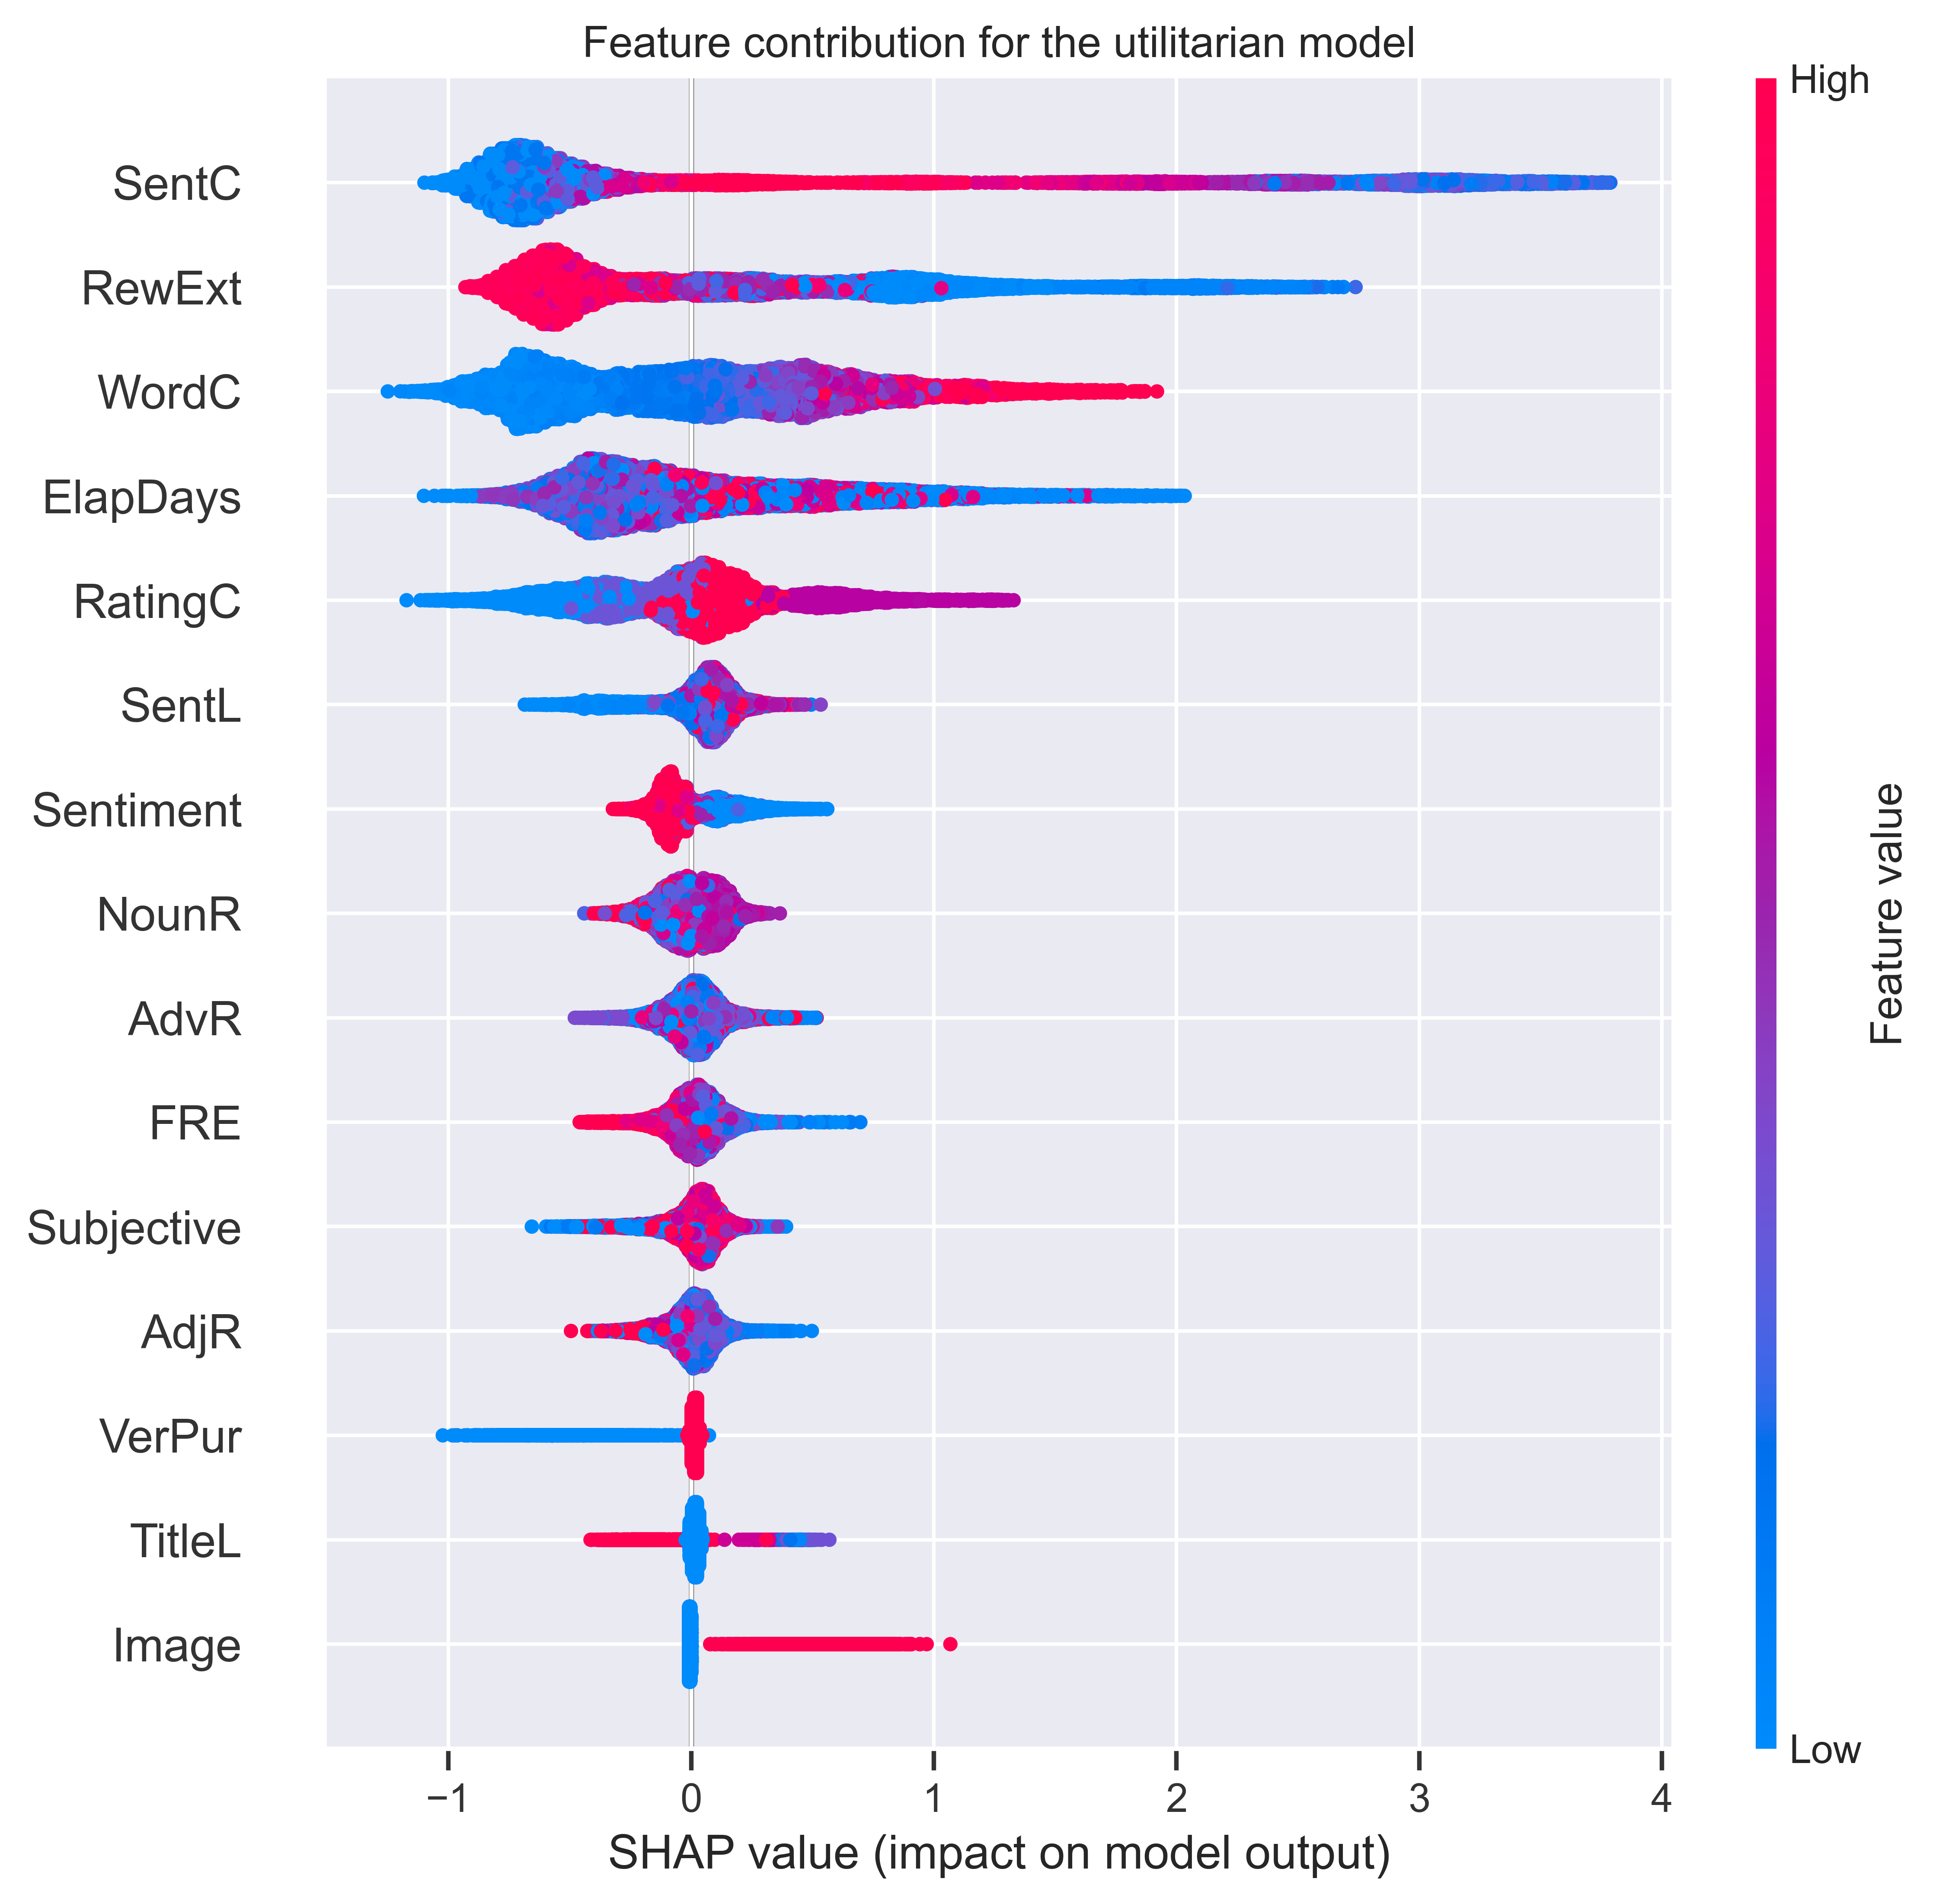

In [20]:
# Compute SHAP values for the best model (XGBoost with hyperparameters)
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(6, 8), dpi=600)   # Create a figure with a specific size and DPI
shap.plots.beeswarm(shap_values, max_display=15,show=False)  # Create the plot without displaying it immediately

# Add title to the plot
plt.title('Feature contribution for the utilitarian model')

plt.tight_layout() 

# Display the plot
plt.show()

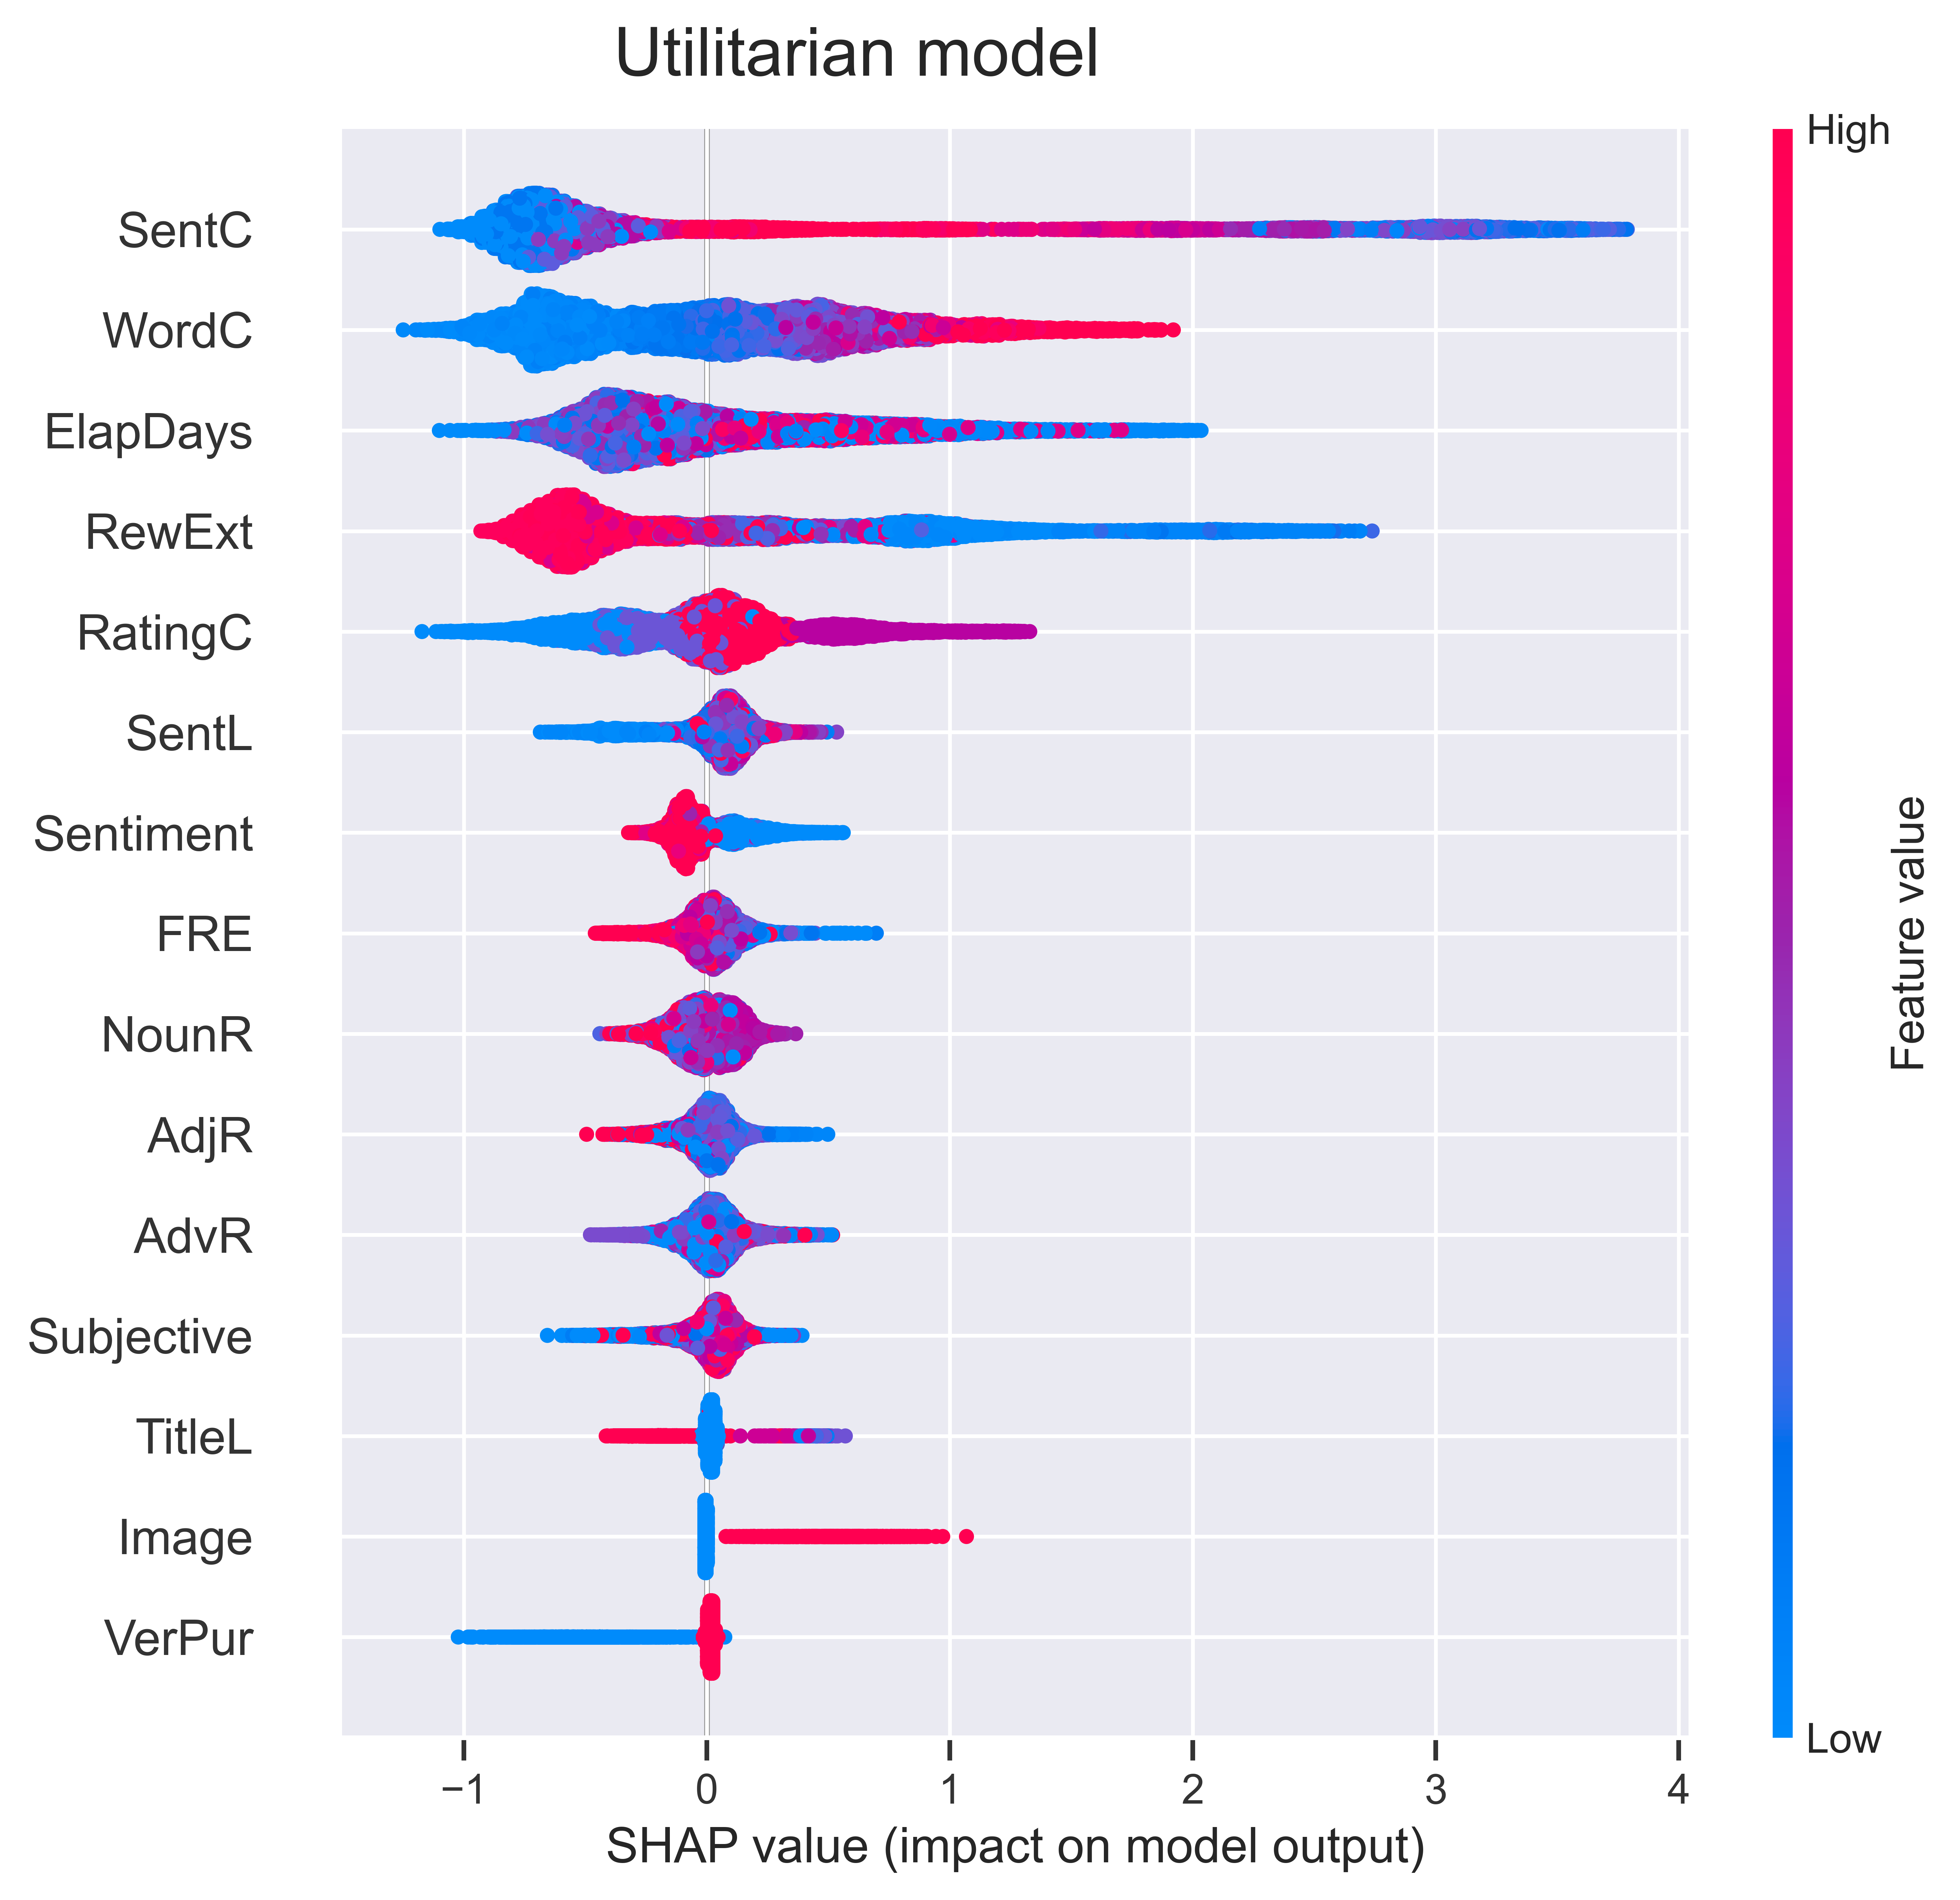

In [21]:
# Define the order of the features for comparision with hedonic feature importance
order = ['SentC','WordC','ElapDays','RewExt','RatingC','SentL','Sentiment', 'FRE','NounR','AdjR', 'AdvR',
         'Subjective','TitleL', 'Image', 'VerPur']

# Create a mapping from column names to their indices
col2num = {col: i for i, col in enumerate(X_train_balanced.columns)}

# Ensure all columns in order exist in the DataFrame and map them to their indices
order = [col2num[col] for col in order if col in col2num]

# Create the beeswarm plot with the correct order
fig, ax = plt.subplots(figsize=(12, 8), dpi=800)  # Set figure size and DPI
shap.plots.beeswarm(shap_values,  max_display=16, show=False, order=order) 


# Add the title above the plot with indentation
plt.suptitle('Utilitarian model', fontsize=18, ha='left',  x=0.25, y=0.95)  

# Adjust the layout to create more space at the top for the title
plt.subplots_adjust(top=0.9) 

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Utilitarian.png', dpi=600, bbox_inches = "tight")  
plt.show()

In [22]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

[13:27:13] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


      features  average_shap_value
4        SentC            0.958600
0       RewExt            0.635061
3        WordC            0.516419
7     ElapDays            0.405763
14     RatingC            0.261127
1    Sentiment            0.122001
5        SentL            0.106281
10       NounR            0.092356
13         FRE            0.081195
12        AdvR            0.078224
2   Subjective            0.076092
11        AdjR            0.062238
9       VerPur            0.047590
8        Image            0.037143
6       TitleL            0.015371


In [23]:
#Saving the SHAP VAlues for utilitarian model in a csv file for later comparison
shap_df_train_sorted.to_csv('/Users/paulahofmann/Documents/Coding/Online-Review/4 Model Building/shap_values_Utilitarian.csv', index=False)